In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')
sys.path.append(gh_dir+'linmix/')
sys.path.append('/Users/ttshimiz/Dropbox/Research/')
import asurv
import linmix

In [2]:
# Setup the figures
style='paper'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
#bat_c12.loc['UGC06728', 'lir_agn'] += 2.0
#bat_c12.loc['UGC06728', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
#bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_c12['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))


# Calculate the SFR
bat_c12['sfr'] = bat_c12['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)
bat_c12['sfr_68_up'] = bat_c12['lir_sf_err_high']
bat_c12['sfr_68_down'] = bat_c12['lir_sf_err_low']
bat_c12['sfr_err'] = np.max(np.vstack([bat_c12['lir_sf_err_high'], bat_c12['lir_sf_err_low']]), axis=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['bat_flux_err_low'] = bat_flux['BAT_flux'] - bat_flux['BAT_flux_90_low']
bat_flux['bat_flux_err_high'] = bat_flux['BAT_flux_90_high'] - bat_flux['BAT_flux']
bat_flux['lbat'] = np.log10(4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12))
bat_flux['bat_err'] = np.max(np.vstack([bat_flux['bat_flux_err_low'], bat_flux['bat_flux_err_high']]), axis=0)
bat_flux['lbat_err'] = 0.434*4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['bat_err']*10**(-12)/(10**bat_flux['lbat'])
bat_flux['lbat_flag'] = pd.Series(index=bat_flux.index)
bat_flux.loc[bat_flux['BAT_flux_90_high'] == 0, 'lbat_flag'] = 0
bat_flux.loc[bat_flux['BAT_flux_90_low'] != 0, 'lbat_flag'] = 1
bat_flux.loc[bat_flux['lbat_flag'] == 0, 'lbat_err'] = 0

bat_c12['lbat'] = bat_flux['lbat']
bat_c12['lbat_err'] = bat_flux['lbat_err']
bat_c12['lbat_flag'] = bat_flux['lbat_flag']

bat_c12['lir_agn_err'] = np.sqrt(np.max(np.vstack([bat_c12['lir_agn_err_low'], bat_c12['lir_agn_err_high']]), axis=0)**2 + 0.25**2)

In [4]:
broad_type = pd.Series(index=bat_info.index, name='Sy_Type')

for n in bat_info.index.values:
129
    type_split = bat_info.loc[n, 'Seyfert_Type'].split()

    if ((type_split[0] == 'Sy')):
        if ((type_split[1] == '1') | (type_split[1] == '1.2') | (type_split[1] == '1.4') | (type_split[1] == '1.5')):

            broad_type.loc[n] = 'Sy 1'
            
        elif ((type_split[1] == '2') | (type_split[1] == '1.8') | (type_split[1] == '1.9')):
            
            broad_type.loc[n] = 'Sy 2'
    else:

        if (type_split[0] == 'LINER'):
            
            broad_type.loc[n] = 'LINER'

        elif (type_split[0] == 'AGN'):
            
            broad_type.loc[n] = 'AGN'

In [5]:
bat_c12['Sy_Type'] = broad_type
bat_sy1 = bat_c12[bat_c12['Sy_Type'] == 'Sy 1']
bat_sy2 = bat_c12[bat_c12['Sy_Type'] == 'Sy 2']

Test for the correlation between the AGN IR luminosity and the BAT luminosity for the whole sample

In [6]:
x = bat_c12['lbat'].values
y = bat_c12['lir_agn'].values
xerr = bat_c12['lbat_err'].values
yerr = bat_c12['lir_agn_err'].values
yerr[np.isnan(yerr)] = np.mean(yerr[~np.isnan(yerr)])
delta = bat_c12['lir_agn_flag'].values
delta[delta == 1] = 0
delta = delta + 1

lm = linmix.LinMix(x=x, y=y, xsig=xerr, ysig=yerr, delta=delta)
lm.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm.chain['beta']), ' +/- ', np.std(lm.chain['beta'])
print 'Intercept = ', np.median(lm.chain['alpha']), ' +/- ', np.std(lm.chain['alpha'])
print 'Sigsqr = ', np.median(lm.chain['sigsqr']), ' +/- ', np.std(lm.chain['sigsqr'])
print 'R^2 = ', np.median(lm.chain['corr']), ' +/- ', np.std(lm.chain['corr'])

Total Sample:
Slope =  0.920799869836  +/-  0.0584940122942
Intercept =  -30.1043981384  +/-  2.54444722386
Sigsqr =  0.131089936229  +/-  0.0212003923475
R^2 =  0.823220156699  +/-  0.0312345903599


Test for the correlation between the total 8-1000 micron luminosity and the BAT luminosity

In [7]:
x = bat_c12['lbat'].values
y_total = bat_c12['lir_total'].values
xerr = bat_c12['lbat_err'].values
yerr_total = bat_c12['lir_total_err_high'].values
yerr_total[np.isnan(yerr_total)] = np.mean(yerr_total[~np.isnan(yerr_total)])
delta = bat_c12['lir_total_flag'].values
delta[delta == 1] = 0
delta = delta + 1

lm = linmix.LinMix(x=x, y=y_total, xsig=xerr, ysig=yerr_total, delta=delta)
lm.run_mcmc(silent=True)
print 'Total Sample:'
print 'Slope = ', np.median(lm.chain['beta']), ' +/- ', np.std(lm.chain['beta'])
print 'Intercept = ', np.median(lm.chain['alpha']), ' +/- ', np.std(lm.chain['alpha'])
print 'Sigsqr = ', np.median(lm.chain['sigsqr']), ' +/- ', np.std(lm.chain['sigsqr'])
print 'R^2 = ', np.median(lm.chain['corr']), ' +/- ', np.std(lm.chain['corr'])

Total Sample:
Slope =  0.410322486004  +/-  0.0493101799626
Intercept =  -7.47643557647  +/-  2.13936969795
Sigsqr =  0.225819170996  +/-  0.0206240483804
R^2 =  0.44096656778  +/-  0.05150520009


In [12]:
x_sy1 = bat_sy1['lbat'].values
y_sy1 = bat_sy1['lir_agn'].values
xerr_sy1 = bat_sy1['lbat_err'].values
yerr_sy1 = bat_sy1['lir_agn_err'].values
#yerr_sy1[np.isnan(yerr_sy1)] = 1.
delta_sy1 = bat_sy1['lir_agn_flag'].values
delta_sy1[delta_sy1 == 1] = 0
delta_sy1 = delta_sy1 + 1

lm_sy1 = linmix.LinMix(x=x_sy1, y=y_sy1, xsig=xerr_sy1, ysig=yerr_sy1, delta=delta_sy1)
lm_sy1.run_mcmc(silent=True)
print 'Sy 1s:'
print 'Slope = ', np.median(lm_sy1.chain['beta']), ' +/- ', np.std(lm_sy1.chain['beta'])
print 'Intercept = ', np.median(lm_sy1.chain['alpha']), ' +/- ', np.std(lm_sy1.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy1.chain['sigsqr']), ' +/- ', np.std(lm_sy1.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy1.chain['corr']), ' +/- ', np.std(lm_sy1.chain['corr'])

Sy 1s:
Slope =  0.929977681674  +/-  0.0831547597818
Intercept =  -30.5033823746  +/-  3.62716716666
Sigsqr =  0.0956316692643  +/-  0.0245185591791
R^2 =  0.849062784616  +/-  0.0436370487208


In [13]:
x_sy2 = bat_sy2['lbat'].values
y_sy2 = bat_sy2['lir_agn'].values
xerr_sy2 = bat_sy2['lbat_err'].values
yerr_sy2 = bat_sy2['lir_agn_err'].values
#yerr_sy2[np.isnan(yerr_sy2)] = 1.
delta_sy2 = bat_sy2['lir_agn_flag'].values
delta_sy2[delta_sy2 == 1] = 0
delta_sy2 = delta_sy2 + 1

lm_sy2 = linmix.LinMix(x=x_sy2, y=y_sy2, xsig=xerr_sy2, ysig=yerr_sy2, delta=delta_sy2)
lm_sy2.run_mcmc(silent=True)
print 'Sy 2s:'
print 'Slope = ', np.median(lm_sy2.chain['beta']), ' +/- ', np.std(lm_sy2.chain['beta'])
print 'Intercept = ', np.median(lm_sy2.chain['alpha']), ' +/- ', np.std(lm_sy2.chain['alpha'])
print 'Sigsqr = ', np.median(lm_sy2.chain['sigsqr']), ' +/- ', np.std(lm_sy2.chain['sigsqr'])
print 'R^2 = ', np.median(lm_sy2.chain['corr']), ' +/- ', np.std(lm_sy2.chain['corr'])

Sy 2s:
Slope =  0.899365126183  +/-  0.0877422977148
Intercept =  -29.1958882332  +/-  3.80565509751
Sigsqr =  0.184309254525  +/-  0.0403122998137
R^2 =  0.770390612531  +/-  0.0511671500995


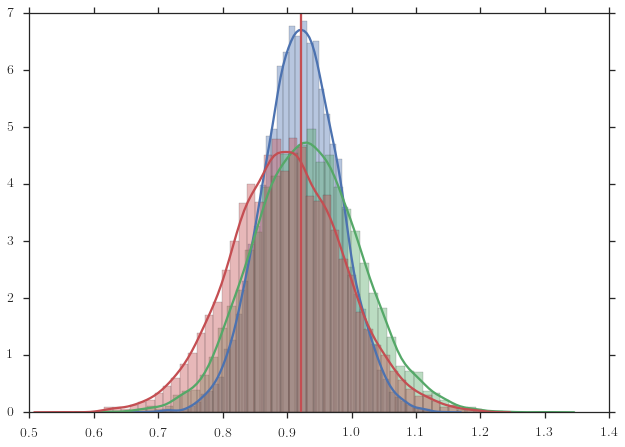

In [16]:
sn.distplot(lm.chain['beta'])
sn.distplot(lm_sy1.chain['beta'])
sn.distplot(lm_sy2.chain['beta'])
plt.axvline(np.median(lm.chain['beta']), color='r')

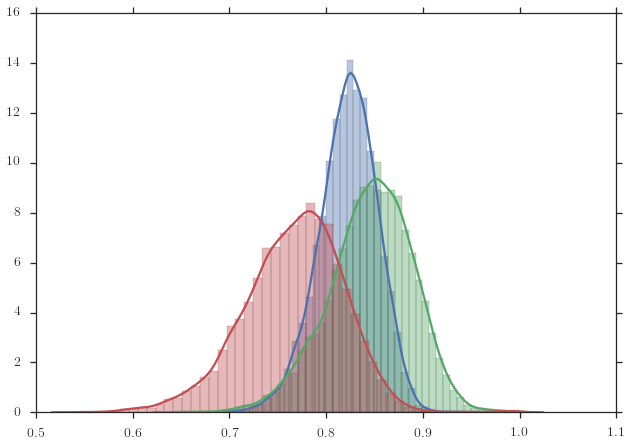

In [17]:
sn.distplot(lm.chain['corr'])
sn.distplot(lm_sy1.chain['corr'])
sn.distplot(lm_sy2.chain['corr'])

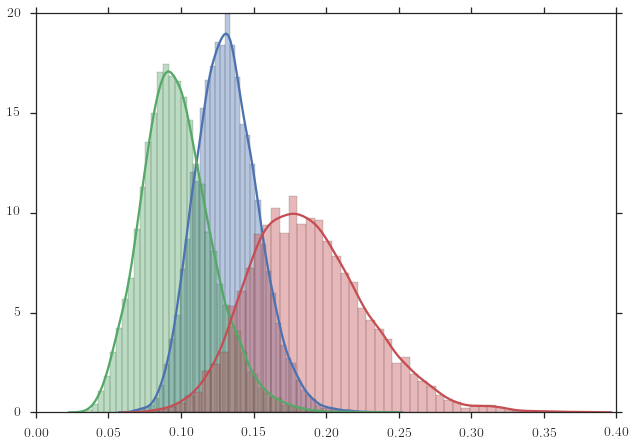

In [18]:
sn.distplot(lm.chain['sigsqr'])
sn.distplot(lm_sy1.chain['sigsqr'])
sn.distplot(lm_sy2.chain['sigsqr'])

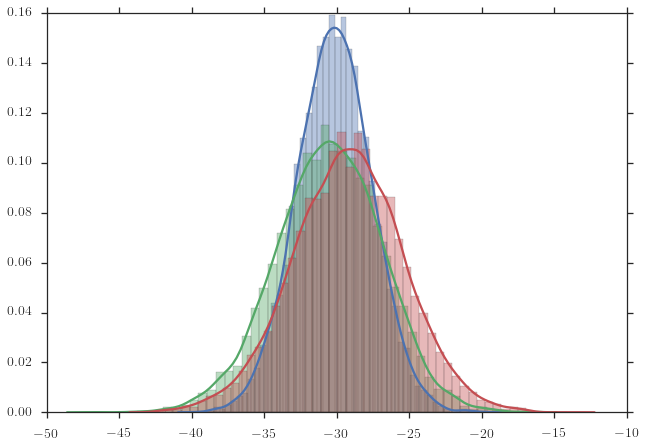

In [19]:
sn.distplot(lm.chain['alpha'])
sn.distplot(lm_sy1.chain['alpha'])
sn.distplot(lm_sy2.chain['alpha'])

In [20]:
xfit = np.arange(41.0, 45.0, 0.001)
yfit_all = np.zeros((len(lm.chain['beta']), len(xfit)))
#yfit_sy1 = np.zeros((len(lm_sy1.chain['beta']), len(xfit)))
#yfit_sy2 = np.zeros((len(lm_sy2.chain['beta']), len(xfit)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_all[i, :] = alpha_i + beta_i*xfit

#    beta_sy1_i = lm_sy1.chain['beta'][i]
#    alpha_sy1_i = lm_sy1.chain['alpha'][i]
#    yfit_sy1[i, :] = alpha_sy1_i + beta_sy1_i*xfit
    
#    beta_sy2_i = lm_sy2.chain['beta'][i]
#    alpha_sy2_i = lm_sy2.chain['alpha'][i]
#    yfit_sy2[i, :] = alpha_sy2_i + beta_sy2_i*xfit


yfit_median = np.median(yfit_all, axis=0)
yfit_upper95 = np.percentile(yfit_all, axis=0, q=97.5)
yfit_lower95 = np.percentile(yfit_all, axis=0, q=2.5)

#yfit_sy1_median = np.median(yfit_sy1, axis=0)
#yfit_sy1_upper95 = np.percentile(yfit_sy1, axis=0, q=97.5)
#yfit_sy1_lower95 = np.percentile(yfit_sy1, axis=0, q=2.5)

#yfit_sy2_median = np.median(yfit_sy2, axis=0)
#yfit_sy2_upper95 = np.percentile(yfit_sy2, axis=0, q=97.5)
#yfit_sy2_lower95 = np.percentile(yfit_sy2, axis=0, q=2.5)

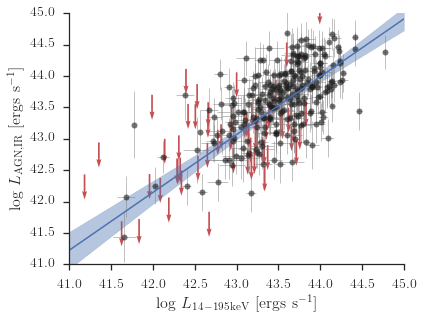

In [26]:
#fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
fig = plt.figure(figsize=(6., 4.5))
ms = 6
#plt.errorbar(x_sy1[delta_sy1==1], y_sy1[delta_sy1==1], xerr=xerr_sy1[delta_sy1==1], yerr=bat_sy1.loc[delta_sy1==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
#             fmt='o', color='b', ls='None', alpha=0.6, label='Type 1', ms=3)
#plt.errorbar(x_sy2[delta_sy2==1], y_sy2[delta_sy2==1], xerr=xerr_sy2[delta_sy2==1], yerr=bat_sy2.loc[delta_sy2==1, ['sfr_68_up', 'sfr_68_down']].values.transpose(),
#             fmt='o', color='r', ls='None', alpha=0.6, label='Type 2', ms=3)
#plt.plot(x_sy1[delta_sy1==0], y_sy1[delta_sy1==0], marker='v', markeredgecolor='b', markerfacecolor='None',
#         markeredgewidth=1.5, ls='None', alpha=0.6, ms=4)
#plt.plot(x_sy2[delta_sy2==0], y_sy2[delta_sy2==0], marker='v', markeredgecolor='r', markerfacecolor='None',
#         markeredgewidth=1.5, ls='None', alpha=0.6, ms=4)
plt.errorbar(x[delta==1], y[delta==1]+np.log10(3.826e33), xerr=xerr[delta==1], yerr=bat_c12.loc[delta==1, 'lir_agn_err'].values.transpose(),
             fmt='o', color='k', ls='None', alpha=0.6, ms=ms, ecolor='grey', elinewidth=0.8)
#plt.plot(x[delta==0], y[delta==0]+np.log10(3.826e33), marker='v', markeredgecolor='b', markerfacecolor='None',
#         markeredgewidth=1.5, ls='None', alpha=0.6, ms=4)
plt.quiver(x[delta==0], y[delta==0]+np.log10(3.826e33), np.zeros(sum(delta==0)), -np.ones(sum(delta==0)), color='r',
           scale_units='height', scale=10., units='width', width=0.005)
plt.plot(xfit, yfit_median+np.log10(3.826e33), 'b-', lw=1.5)
plt.fill_between(xfit, yfit_lower95+np.log10(3.826e33), yfit_upper95+np.log10(3.826e33), color='b', alpha=0.4)
#plt.plot(xfit, yfit_sy1_median, 'b-', lw=1.5)
#plt.fill_between(xfit, yfit_sy1_lower95, yfit_sy1_upper95, color='b', alpha=0.3)
#plt.plot(xfit, yfit_sy2_median, 'r-', lw=1.5)
#plt.fill_between(xfit, yfit_sy2_lower95, yfit_sy2_upper95, color='r', alpha=0.3)
plt.xlim(41.0, 45.0)
plt.ylim(41.0, 45.0)
plt.xlabel(r'$\log\,L_{\rm 14-195\,keV}$ [ergs s$^{-1}$]')
plt.ylabel(r'$\log\,L_{\rm AGN, IR}$ [ergs s$^{-1}$]')
#plt.legend(loc='upper left', fontsize=10)
sn.despine()
fig.savefig('/Users/ttshimiz/Dropbox/Research/Thesis/Dissertation/presentation/lagnIR_lbat_correlation.pdf', bbox_inches='tight')

In [8]:
reload(asurv)
delta_kendall = delta - 1
bat_c12['Dist'] = bat_info['Dist_[Mpc]']
z = bat_c12['Dist'].values
z_censor = np.zeros(len(z))

tau_lagnIR_lbat = asurv.partial_kendalltau(x, np.zeros(len(x)), y, delta_kendall, z, z_censor)

In [10]:
data = np.vstack([x, np.ones(len(x)), y+np.log10(3.826e33), delta, z, np.ones(len(z))])
np.savetxt('lagnIR_vs_lbat.dat', data.transpose(), fmt = ['%10.6g', '%i', '%10.6g', '%i', '%10.6g', '%i'])

In [9]:
tau_lagnIR_lbat

0.31758024277593555

In [34]:
bat_c12[['lbat', 'lir_agn', 'Dist']]

,lbat,lir_agn,Dist
Name,,,
1RXSJ044154.5-082639,43.667182,10.133925,194.766735
1RXSJ045205.0+493248,44.086919,10.180250,126.962397
2E1739.1-1210,44.151575,10.589410,162.946050
2MASSJ07594181-3843560,44.277333,10.462743,176.545356
2MASSJ17485512-3254521,43.522090,8.989348,86.973192
2MASXJ00253292+6821442,42.769966,9.474214,51.868896
2MASXJ01064523+0638015,43.783850,10.426222,181.091182
2MASXJ01073963-1139117,43.746427,10.528412,210.605342
2MASXJ03305218+0538253,43.740209,10.734672,203.915430
